In [1]:
# use precomputed permutations to align 2 checkpoints
import torch
import numpy as np
import sys

sys.path.append("../")
from nnperm.perm import PermutationSpec
from nnperm.utils import to_numpy


## Setup
perm_b2a = "../refactor-outputs/layer-align-more-bias/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_1-2/perm-linear-ep150_it0-final-all.pt"
perm, perm_spec = PermutationSpec.load_from_file(perm_b2a)
params_a = torch.load("../refactor-outputs/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_1/level_0/main/model_ep150_it0.pth", map_location="cpu")
params_b = torch.load("../refactor-outputs/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_2/level_0/main/model_ep150_it0.pth", map_location="cpu")
params_a = to_numpy(params_a)
params_b = to_numpy(params_b)
params_b2a = perm_spec.apply_permutation(params_b, perm)

In [2]:
def del_other_keys(a: dict, keys):
    for k in list(a.keys()):
        if k not in keys:
            del a[k]
    return a

selected_keys = ["layers.0.conv.weight", "layers.0.conv.bias", "layers.7.conv.weight", "layers.7.conv.bias", "layers.14.conv.weight", "layers.14.conv.bias"]
params_a = del_other_keys(params_a, selected_keys)
params_b = del_other_keys(params_b, selected_keys)
params_b2a = del_other_keys(params_b2a, selected_keys)

In [3]:
# sanity check: permuted_b should be closer than params_b in L2 norm to params_a
def l2_norm(a: dict, b: dict, ord=None):
    norms = {}
    for k in a.keys():
        norms[k] = np.linalg.norm(a[k].flatten() - b[k].flatten(), ord=ord)
    return norms

diff_id = l2_norm(params_a, params_b)
diff_perm = l2_norm(params_a, params_b2a)
for k in diff_id.keys():
    print(k, params_a[k].shape, diff_id[k], diff_perm[k])
    assert diff_id[k] >= diff_perm[k]

layers.0.conv.weight (64, 3, 3, 3) 20.042692 11.55805
layers.0.conv.bias (64,) 5.781991 4.5818295
layers.7.conv.weight (256, 256, 3, 3) 41.522217 39.37718
layers.7.conv.bias (256,) 1.5963371 1.1849145
layers.14.conv.weight (512, 512, 3, 3) 11.2056465 9.44325
layers.14.conv.bias (512,) 0.5987972 0.32899716


In [4]:
# take midpoint of linear interpolation
from nnperm.error import interpolate_dict

interpolated_id = interpolate_dict(params_a, params_b, alpha=0.5)
interpolated_perm = interpolate_dict(params_a, params_b2a, alpha=0.5)
for k in interpolated_perm.keys():
    norm_a = np.linalg.norm(params_a[k].flatten())
    norm_perm = np.linalg.norm(interpolated_perm[k].flatten())
    norm_id = np.linalg.norm(interpolated_id[k].flatten())
    print(k, params_a[k].shape, norm_a, norm_perm, norm_id)
    assert norm_a >= norm_perm


layers.0.conv.weight (64, 3, 3, 3) 14.196178 12.948657 10.031823
layers.0.conv.bias (64,) 4.3534446 3.6920345 3.2436945
layers.7.conv.weight (256, 256, 3, 3) 29.379341 21.781517 20.761772
layers.7.conv.bias (256,) 1.1474999 0.96564215 0.80398846
layers.14.conv.weight (512, 512, 3, 3) 7.967174 6.363615 5.603424
layers.14.conv.bias (512,) 0.4349517 0.40025857 0.31245348


In [5]:
# take vector norms w.r.t. output channels
def vector_norm(tensors: dict, channel=0):
    out = {}
    for k, v in tensors.items():
        out[k] = np.linalg.norm(v.reshape(v.shape[0], -1), axis=1)
    return out

vec_a = vector_norm(params_a)
vec_b = vector_norm(params_b)
vec_b2a = vector_norm(params_b2a)
vec_int_id = vector_norm(interpolated_id)
vec_int_perm = vector_norm(interpolated_perm)

diff_id = l2_norm(vec_a, vec_b)
diff_perm = l2_norm(vec_a, vec_b2a)
for k in diff_id.keys():
    print(k, vec_a[k].shape, diff_id[k], diff_perm[k])
    assert diff_id[k] >= diff_perm[k]

layers.0.conv.weight (64,) 7.820647 4.0891514
layers.0.conv.bias (64,) 3.776227 3.0492892
layers.7.conv.weight (256,) 8.338877 4.90214
layers.7.conv.bias (256,) 0.96855736 0.87868196
layers.14.conv.weight (512,) 5.193024 2.252285
layers.14.conv.bias (512,) 0.41213262 0.2748492


In [6]:
# for each layer:
# 1. plot weight magnitude at a and b with and without permutation
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns


def magnitude_abs(a: dict):
    return {k: np.abs(v) for k, v in a.items()}

def scatter_a_b(a: dict, b: dict, xlabel="", ylabel=""):
    keys = list(a.keys())
    ncols = len(keys)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*4, 4))
    for k, ax in zip(keys, axes):
        x = np.abs(a[k].flatten())
        y = np.abs(b[k].flatten())
        correlation, p_value = pearsonr(x, y)
        ax.set_title(f"{k}\n$R^2={correlation**2:0.2f}$ $p={p_value:0.2f}$")
        sns.histplot(x=x, y=y, ax=ax)
        lim_min = min(ax.get_xlim()[1], ax.get_ylim()[1])
        lim_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.set_xlabel(xlabel)
        if k == keys[0]:
            ax.set_ylabel(ylabel)
        ax.set_xlim(0, lim_max)
        ax.set_ylim(0, lim_max)
        ax.axline((0, 0), (lim_min, lim_min))
    plt.show()

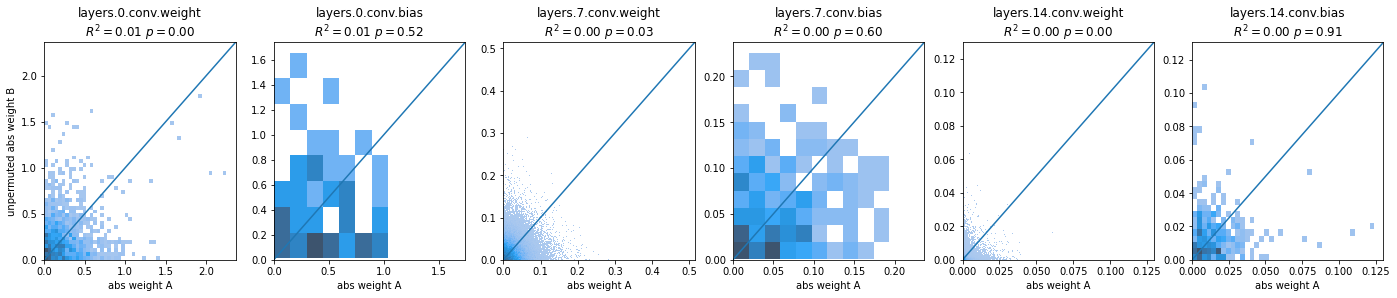

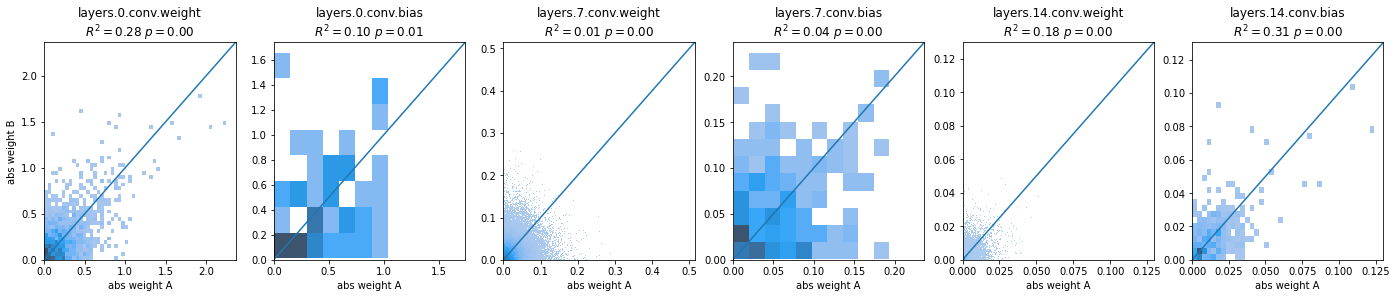

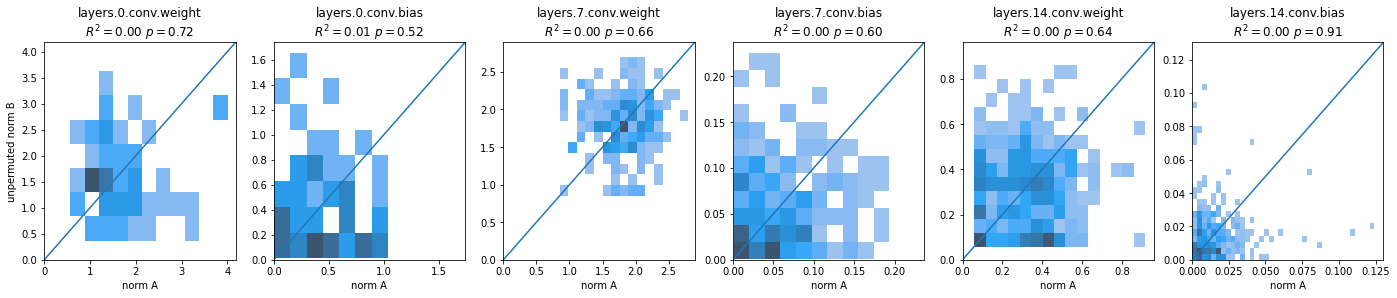

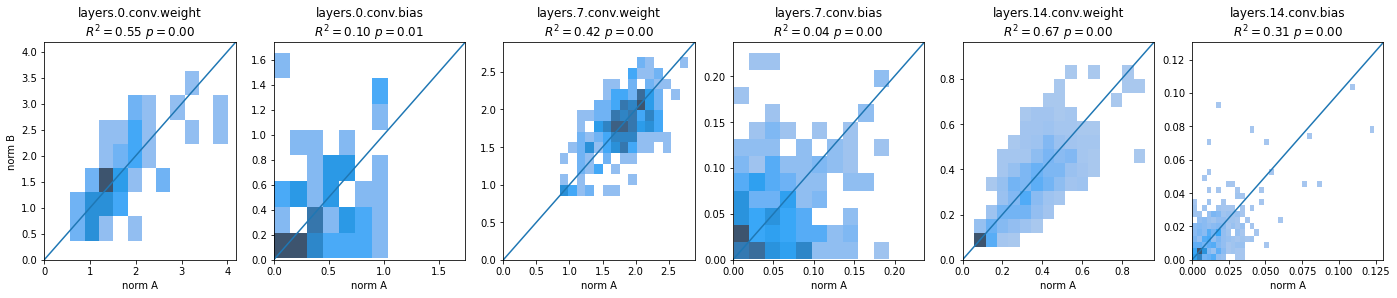

In [26]:
scatter_a_b(params_a, params_b, "abs weight A", "unpermuted abs weight B")
scatter_a_b(params_a, params_b2a, "abs weight A", "abs weight B")
scatter_a_b(vec_a, vec_b, "norm A", "unpermuted norm B")
scatter_a_b(vec_a, vec_b2a, "norm A", "norm B")

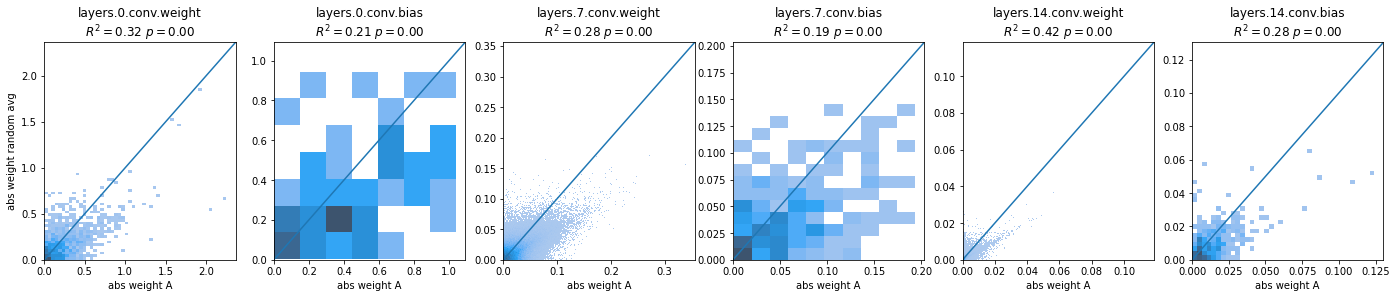

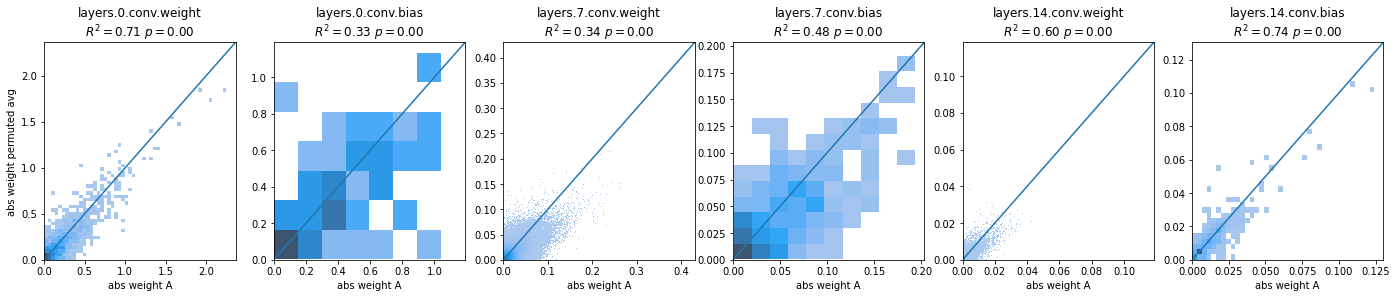

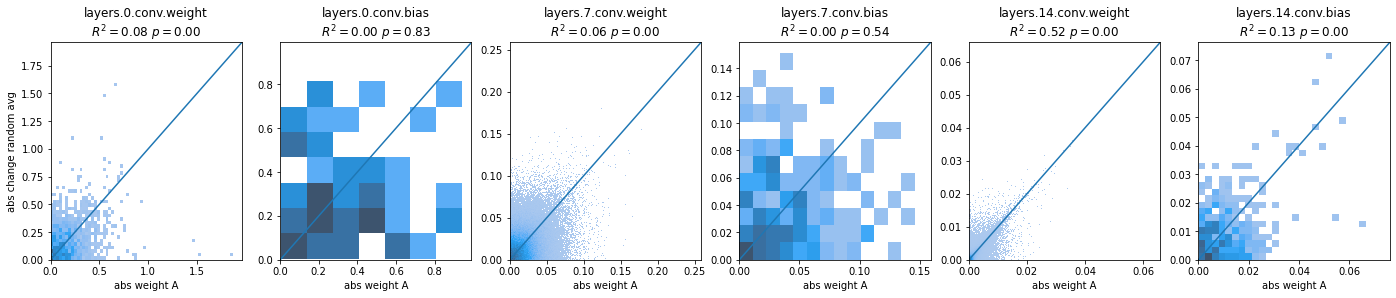

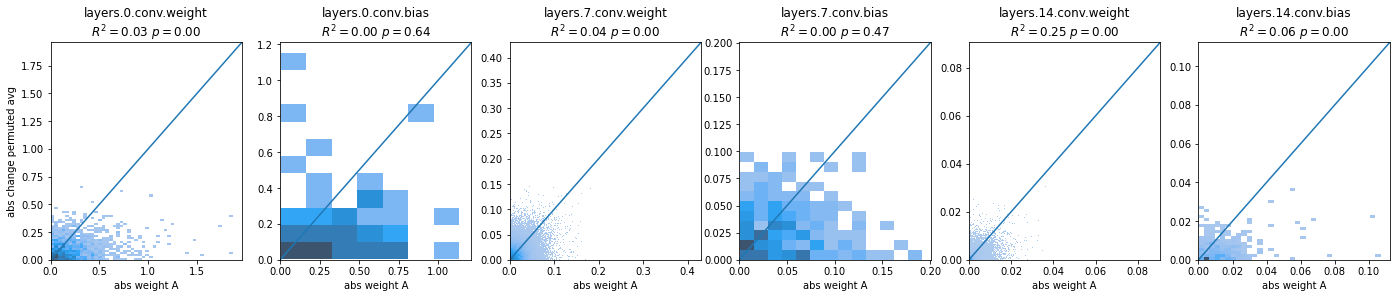

In [27]:
# 2. plot change in magnitude after interpolating
diff_a_int_perm = {k: params_a[k] - interpolated_perm[k] for k in params_a.keys()}
diff_a_int_id = {k: params_a[k] - interpolated_id[k] for k in params_a.keys()}
diff_b2a_int_perm = {k: params_b2a[k] - interpolated_perm[k] for k in params_a.keys()}

# magnitudes before and after interpolation
scatter_a_b(params_a, interpolated_id, "abs weight A", "abs weight random avg")  # control
scatter_a_b(params_a, interpolated_perm, "abs weight A", "abs weight permuted avg")  # a
# magnitudes versus change in magnitudes
scatter_a_b(interpolated_id, diff_a_int_id, "abs weight A", "abs change random avg")
scatter_a_b(interpolated_perm, diff_a_int_perm, "abs weight A", "abs change permuted avg")

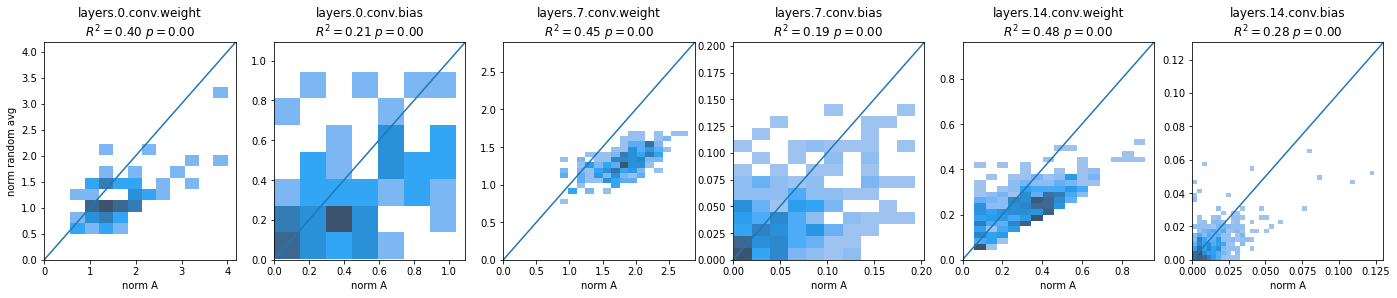

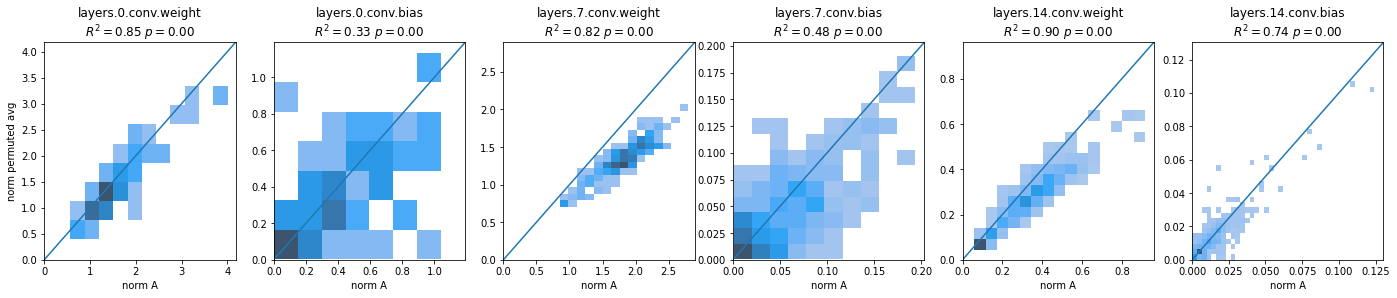

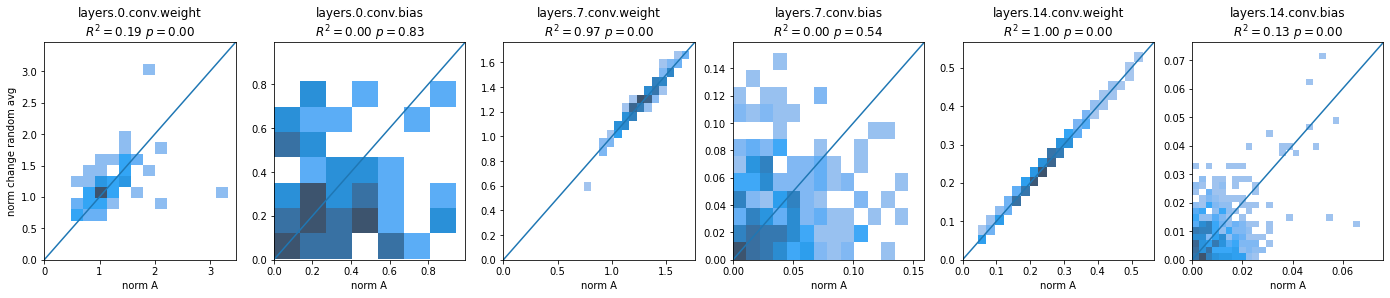

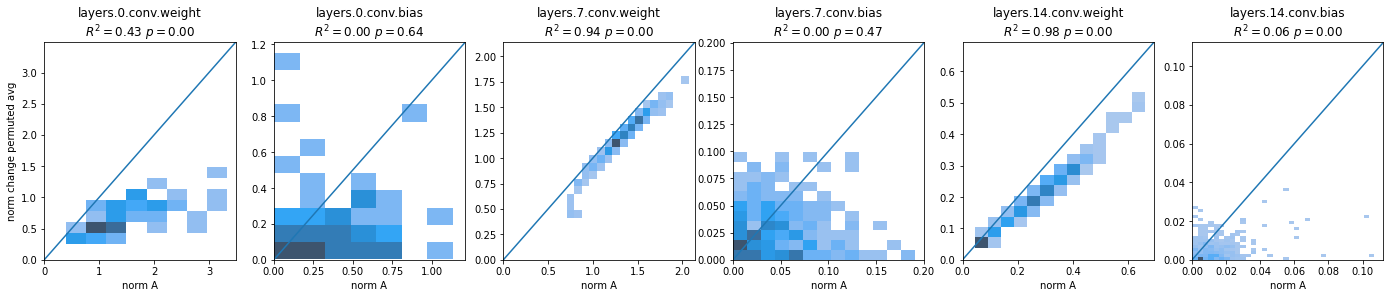

In [28]:
# magnitudes of vectors
scatter_a_b(vec_a, vec_int_id, "norm A", "norm random avg")  # control
scatter_a_b(vec_a, vec_int_perm, "norm A", "norm permuted avg")  # a
# magnitude versus change in magnitude
scatter_a_b(vec_int_id, vector_norm(diff_a_int_id), "norm A", "norm change random avg")
scatter_a_b(vec_int_perm, vector_norm(diff_a_int_perm), "norm A", "norm change permuted avg")

In [7]:
# cosine similarity to magnitude over output dim
def cos_sim(a: dict, b: dict, channel=0):
    out = {}
    for k, v in a.items():
        v_a = a[k].reshape(a[k].shape[0], -1)
        v_b = b[k].reshape(b[k].shape[0], -1)
        out[k] = np.diag(v_a @ v_b.T) / np.linalg.norm(v_a, axis=-1) / np.linalg.norm(v_b, axis=-1)
    return out

sim_id = cos_sim(params_a, params_b)
sim_perm = cos_sim(params_a, params_b2a)
for k in params_a.keys():
    diff = sim_perm[k] - sim_id[k]
    print(np.min(diff), np.max(diff), np.min(sim_perm[k]), np.max(sim_perm[k]))
    if "weight" in k:
        assert np.all(diff >= -1e-2)
    assert np.all(sim_perm[k] >= -1.001) and np.all(sim_perm[k] <= 1.001)

0.0 1.465683 0.25554326 0.9461017
-2.0 2.0 -1.0000001 1.0000001
-0.00066455454 0.6100678 0.01199726 0.6116642
-2.0 2.0 -1.0000001 1.0000001
0.045086995 0.47537112 0.096846506 0.45414975
-2.0 2.0 -1.0000001 1.0000001


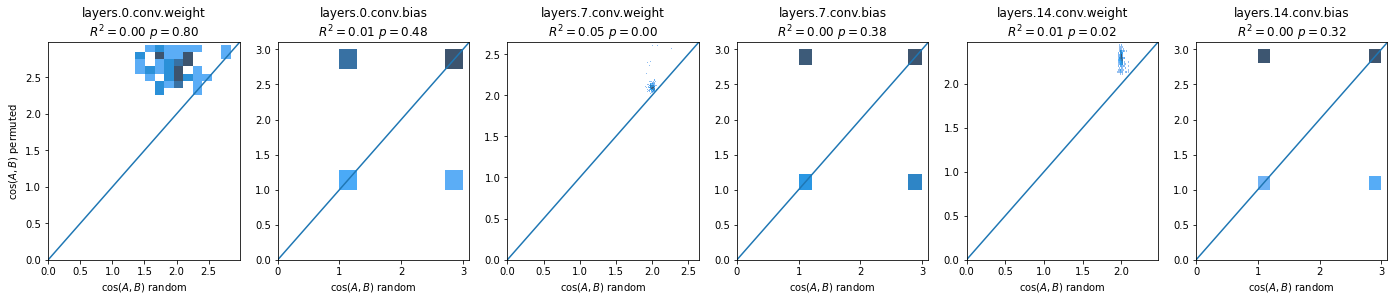

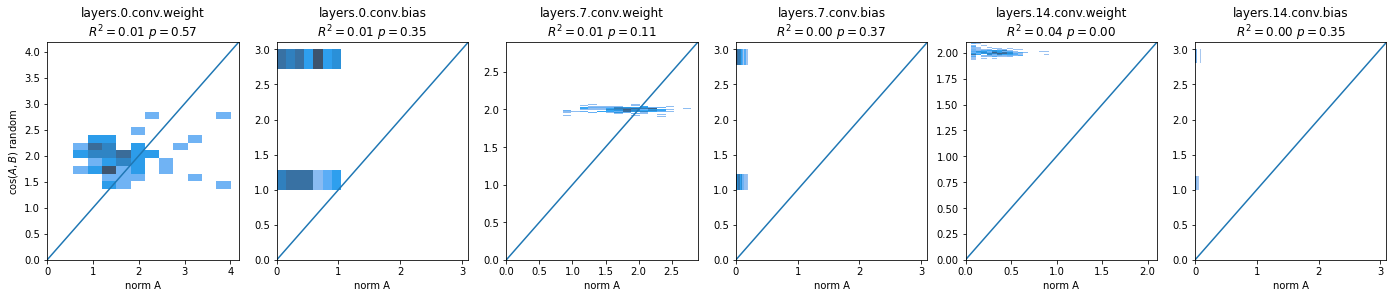

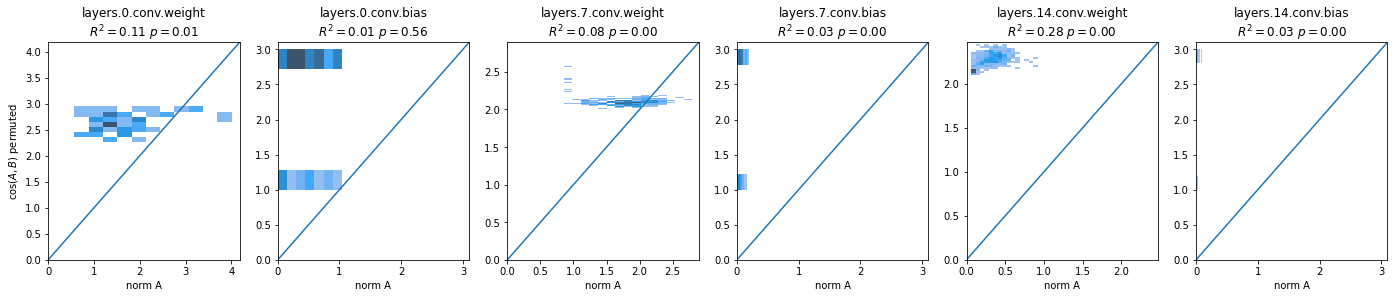

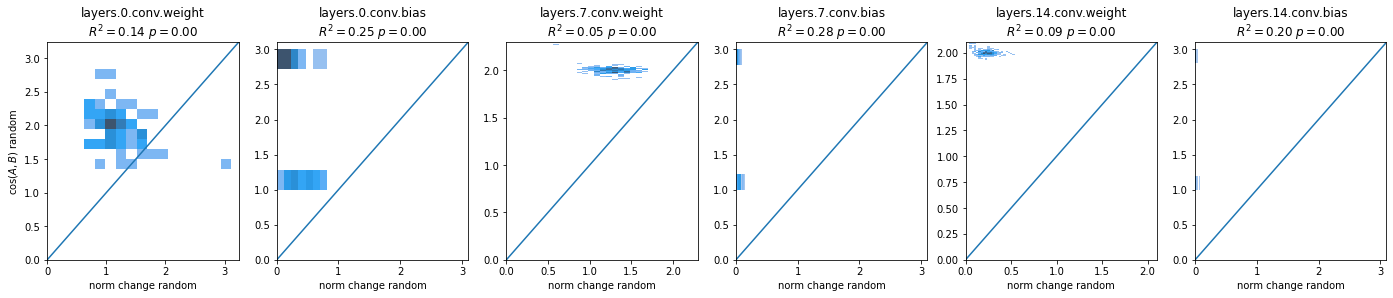

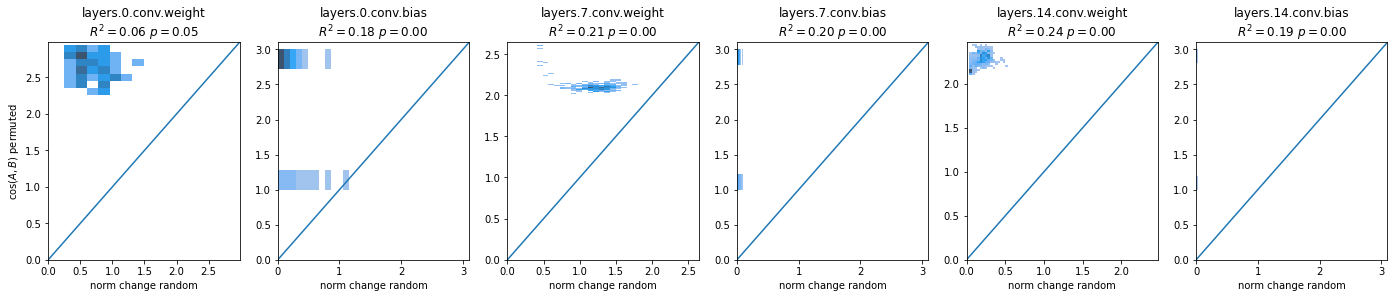

In [29]:
sim_id = {k: v + 1 for k, v in sim_id.items()}
sim_perm = {k: v + 1 for k, v in sim_perm.items()}
scatter_a_b(sim_id, sim_perm, "$\cos(A, B)$ random", "$\cos(A, B)$ permuted")
# norm vs cosine
scatter_a_b(vec_a, sim_id, "norm A", "$\cos(A, B)$ random")
scatter_a_b(vec_a, sim_perm, "norm A", "$\cos(A, B)$ permuted")
# diff vs cosine
scatter_a_b(vector_norm(diff_a_int_id), sim_id, "norm change random", "$\cos(A, B)$ random")
scatter_a_b(vector_norm(diff_a_int_perm), sim_perm, "norm change random", "$\cos(A, B)$ permuted")

In [8]:
# check R^2 of earlier permutations
import pandas as pd

params_b_full = torch.load("../refactor-outputs/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_2/level_0/main/model_ep150_it0.pth", map_location="cpu")

def permutations_by_epoch(fixed_params):
    for ep in [0, 1, 3, 5, 10, 20, 50, 80, 110, 150]:
        file = "../refactor-outputs/layer-align-more-bias/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_1-2/"
        if ep == 0:
            file += f"perm-linear-ep150_it0-identity-all.pt"
        elif ep == 150:
            file += "perm-linear-ep150_it0-final-all.pt"
        else:
            file += f"perm-linear-ep{ep}_it0-ckpt-none.pt"
        p, ps = PermutationSpec.load_from_file(file)
        params_ep = ps.apply_permutation(params_b_full, p)
        params_ep = del_other_keys(params_ep, selected_keys)
        yield ep, fixed_params, params_ep

def plot_correlations(params_iterable, norm=False, interpolate=False, cosine=False):
    outputs = []
    for ep, params, params_ep in params_iterable:
        if interpolate:
            params_ep = interpolate_dict(params, params_ep, 0.5)
        if norm:
            x, y = vec_a, vector_norm(params_ep)
        else:
            x, y = params, params_ep
        if cosine:
            assert not norm
            cos = cos_sim(params, params_ep)
        for k in y.keys():
            if cosine:
                for value in cos[k]:
                    outputs.append({
                        "layer": int(k.split(".")[1]),
                        "type": "bias" if "bias" in k else "weight",
                        "epoch": ep,
                        "$\cos$": value,
                        })
            else:
                correlation, p_value = pearsonr(x[k].flatten(), y[k].flatten())
                outputs.append({
                    "layer": int(k.split(".")[1]),
                    "type": "bias" if "bias" in k else "weight",
                    "epoch": ep,
                    "$R^2$": correlation**2,
                    "$p$ value": p_value,
                    })
    df = pd.DataFrame(outputs)
    plt.title(f"{'Cosine similarity' if cosine else 'Correlation'} of {'vector norms' if norm else 'weights'} between {'$A$ and permuted avg' if interpolate else '$A$ and $B$'}")
    ax = sns.lineplot(data=df, x="epoch", y="$\cos$" if cosine else "$R^2$", hue="layer", style="type")
    ax.set_xlim(0, 150)
    ax.set_ylim(0., 1.)
    plt.show()

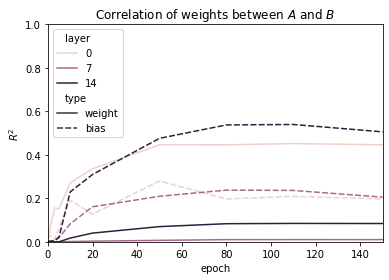

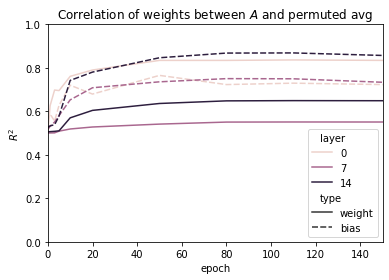

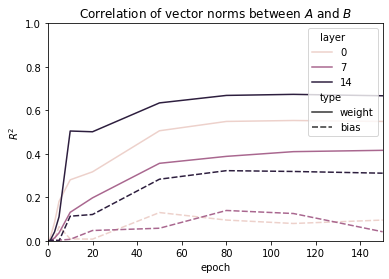

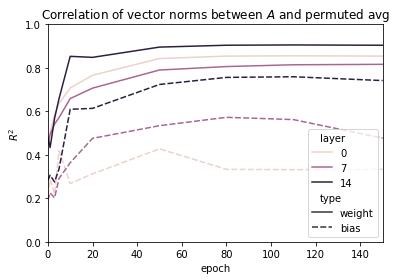

,layer,type,epoch,$R^2$,$p$ value
0,0,weight,0,0.397910,2.311379e-08
1,0,bias,0,0.212987,1.238727e-04
2,7,weight,0,0.449285,9.300302e-35
3,7,bias,0,0.190020,2.685323e-13
4,14,weight,0,0.480347,1.633653e-74
5,14,bias,0,0.281695,1.512387e-38
6,0,weight,1,0.502205,5.696641e-11
7,0,bias,1,0.287170,5.034963e-06
8,7,weight,1,0.494115,1.840765e-39
9,7,bias,1,0.225074,8.980507e-16


In [53]:
plot_correlations(permutations_by_epoch(params_a), False, False)
plot_correlations(permutations_by_epoch(params_a), False, True)
plot_correlations(permutations_by_epoch(params_a), True, False)
plot_correlations(permutations_by_epoch(params_a), True, True)
plot_correlations(permutations_by_epoch(params_a), False, False, True)
plot_correlations(permutations_by_epoch(params_a), False, True, True)

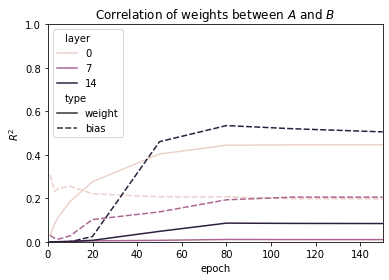

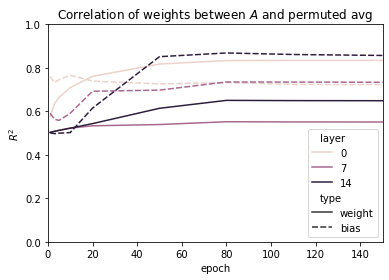

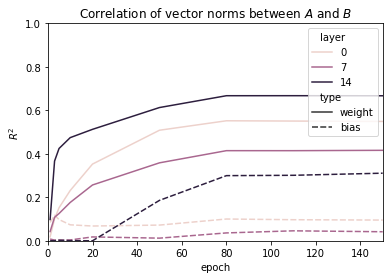

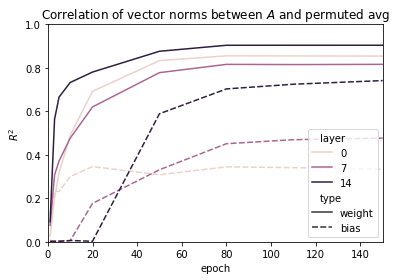

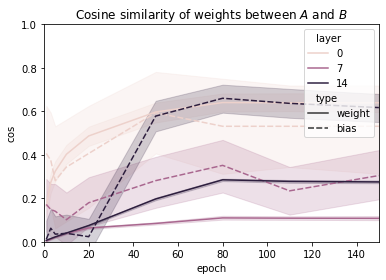

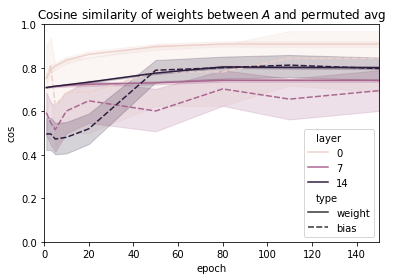

,layer,type,epoch,$\cos$
0,0,weight,1,0.755484
1,0,weight,1,0.712674
2,0,weight,1,0.734600
3,0,weight,1,0.797951
4,0,weight,1,0.781365
...,...,...,...,...
14971,14,bias,150,1.000000
14972,14,bias,150,1.000000
14973,14,bias,150,1.000000
14974,14,bias,150,1.000000


In [16]:
# compute weight magnitude and correlation over epoch checkpoints for fixed permutation P_150
def parameters_by_epoch():
    perm_b2a = "../refactor-outputs/layer-align-more-bias/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_1-2/perm-linear-ep150_it0-final-all.pt"
    perm, perm_spec = PermutationSpec.load_from_file(perm_b2a)
    for ep in [1, 3, 5, 10, 20, 50, 80, 110, 150]:
        params_a = torch.load(f"../refactor-outputs/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_1/level_0/main/model_ep{ep}_it0.pth", map_location="cpu")
        params_b = torch.load(f"../refactor-outputs/lottery_8146fc7e9839615729ee764a8019bdc5/replicate_2/level_0/main/model_ep{ep}_it0.pth", map_location="cpu")
        params_a = to_numpy(params_a)
        params_b = to_numpy(params_b)
        params_b2a = perm_spec.apply_permutation(params_b, perm)
        params_a = del_other_keys(params_a, selected_keys)
        params_b2a = del_other_keys(params_b2a, selected_keys)
        yield ep, params_a, params_b2a

plot_correlations(parameters_by_epoch(), False, False)
plot_correlations(parameters_by_epoch(), False, True)
plot_correlations(parameters_by_epoch(), True, False)
plot_correlations(parameters_by_epoch(), True, True)
plot_correlations(parameters_by_epoch(), False, False, True)
plot_correlations(parameters_by_epoch(), False, True, True)

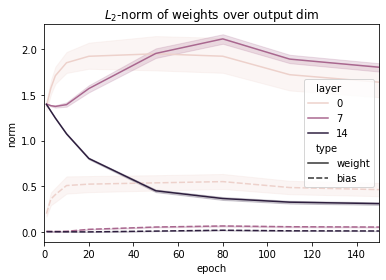

In [19]:
def plot_magnitudes_by_ep():
    outputs = []
    for ep, params, params_ep in parameters_by_epoch():
        norms = vector_norm(params)
        for k, v in norms.items():
            for norm in v:
                outputs.append({
                    "layer": int(k.split(".")[1]),
                    "type": "bias" if "bias" in k else "weight",
                    "epoch": ep,
                    "norm": norm,
                    })
    df = pd.DataFrame(outputs)
    plt.title(f"{'$L_2$-norm of weights over output dim'}")
    ax = sns.lineplot(data=df, x="epoch", y="norm", hue="layer", style="type")
    ax.set_xlim(0, 150)
    plt.show()

plot_magnitudes_by_ep()

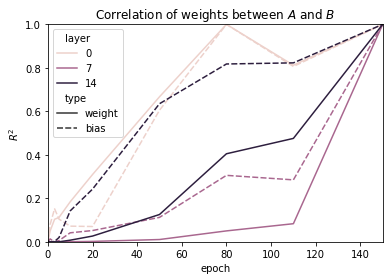

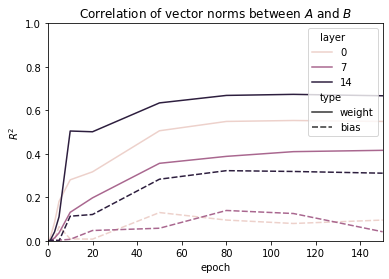

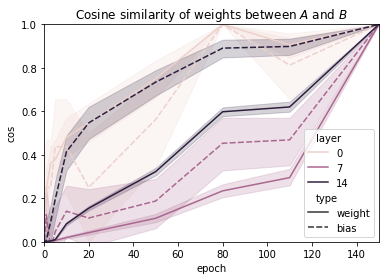

In [10]:
# compute correlation between P_150 weights and P_t weights, to confirm that fixed points predict weight similarity
plot_correlations(permutations_by_epoch(params_b2a), False, False)
plot_correlations(permutations_by_epoch(params_b2a), True, False)
plot_correlations(permutations_by_epoch(params_b2a), False, False, True)